In [1]:
import os
import sys
import random

import numpy as np
# from PIL import Image 
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import datetime as dt
import pandas as pd
# from sklearn.model_selection import train_test_split
import cv2

In [2]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
from tensorflow.keras import backend as K

In [4]:
sm.set_framework('tf.keras')

In [5]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [6]:
train_path = r"C:\yasin\finalData"
checkPoint=r"C:\yasin\finalData\backup"
data = pd.read_csv(r"C:\yasin\finalData\train.csv")

In [7]:
data

,Unnamed: 0,patient,dicom_path,mask_path,size
0,0,abdullah_celik,finalData\img\abdullah_celik\56.jpg,finalData\mask\abdullah_celik\56.jpg,17641
1,1,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\28.jpg,finalData\mask\Ahmet_Ozturk\28.jpg,24082
2,2,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\29.jpg,finalData\mask\Ahmet_Ozturk\29.jpg,25368
3,3,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\30.jpg,finalData\mask\Ahmet_Ozturk\30.jpg,25961
4,4,ahmet_tamturk,finalData\img\ahmet_tamturk\18.jpg,finalData\mask\ahmet_tamturk\18.jpg,13545
...,...,...,...,...,...
338,338,Yilmaz_Tek,finalData\img\Yilmaz_Tek\46.jpg,finalData\mask\Yilmaz_Tek\46.jpg,36721
339,339,Yilmaz_Tek,finalData\img\Yilmaz_Tek\47.jpg,finalData\mask\Yilmaz_Tek\47.jpg,38514
340,340,Yilmaz_Tek,finalData\img\Yilmaz_Tek\80.jpg,finalData\mask\Yilmaz_Tek\80.jpg,9288
341,341,Zehra_Yavuz,finalData\img\Zehra_Yavuz\47.jpg,finalData\mask\Zehra_Yavuz\47.jpg,22916


In [8]:
thresh = 127
class DataGen(keras.utils.Sequence):
    def __init__(self, data, shuffle = False, batch_size=16,
                 image_size = 512,
                 preprocess=None, info={}):
        self.data = data               
        self.batch_size = batch_size 
        self.image_size = image_size        
        self.preprocess = preprocess        
        self.shuffle = shuffle              
        self.on_epoch_end()
        self.color_mode="grayscale"
        
    def __getitem__(self, index):
        images = []
        masks  = []        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        raw= self.data.iloc[indexes]
        for i,row in raw.iterrows(): 
            try:
#                 d_filepath=row["dicom_path"]
                X=cv2.imread(row["dicom_path"], cv2.IMREAD_GRAYSCALE)
                X=X[90:422, 90:422]
                X = cv2.resize(X, (self.image_size , self.image_size))    
                X_std = (X - X.min()) / (X.max() - X.min())
                X = X_std * 255                
                images.append(X)                
                mask=cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)
                mask=mask[90:422, 90:422]
                mask = cv2.resize(mask, (self.image_size , self.image_size ),-1)                     
                mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1] 
                mask=mask.astype(bool)
                masks.append(mask)
            except Exception as e:                
                print(e)
        
        images = np.array(images)
        masks  = np.array(masks)
        
#         if self.preprocess!=None: images = self.preprocess(images)
        
        return images,masks
        
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)



In [25]:
image_size = 288
batch_size = 10

In [26]:
BACKBONE = 'vgg19'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Linknet(BACKBONE,input_shape=(image_size, image_size, 1), 
                encoder_weights=None, activation='sigmoid')
#                 classes=1, activation='softmax')

In [27]:
data = data.sample(frac=1).reset_index(drop=True)
idx = int(0.8*len(data))
train_gen = DataGen(data.iloc[:idx], shuffle =True, batch_size=batch_size,   
                    image_size = image_size,
                    preprocess=preprocess_input)
valid_gen = DataGen(data.iloc[idx:], batch_size=50,   
                    image_size = image_size,
                    preprocess=preprocess_input)

In [28]:
model.compile(
    'SGD',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkPoint+"/vgg16_model_best.hdf5", 
                                               monitor='val_iou_score', 
                                               verbose=1, 
                                               save_best_only=True, 
                                               mode='max')
callbacks = [checkpoint]

In [30]:
history =model.fit(train_gen,
          validation_data=valid_gen, 
          epochs=150,
          callbacks=callbacks,
         )

Epoch 1/150
27/27 [==============================] - ETA: 0s - loss: 1.3089 - iou_score: 8.6004e-04
Epoch 00001: val_iou_score improved from -inf to 0.00075, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 32s 1s/step - loss: 1.3089 - iou_score: 8.6004e-04 - val_loss: 1.4625 - val_iou_score: 7.4858e-04
Epoch 2/150
27/27 [==============================] - ETA: 0s - loss: 1.1377 - iou_score: 8.6523e-04
Epoch 00002: val_iou_score improved from 0.00075 to 0.00085, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 931ms/step - loss: 1.1377 - iou_score: 8.6523e-04 - val_loss: 1.3197 - val_iou_score: 8.4563e-04
Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 1.0865 - iou_score: 9.2693e-04
Epoch 00003: val_iou_score improved from 0.00085 to 0.00092, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 93

Epoch 25/150
27/27 [==============================] - ETA: 0s - loss: 0.9648 - iou_score: 0.0458
Epoch 00025: val_iou_score did not improve from 0.00685
27/27 [==============================] - 25s 923ms/step - loss: 0.9648 - iou_score: 0.0458 - val_loss: 1.0090 - val_iou_score: 0.0019
Epoch 26/150
27/27 [==============================] - ETA: 0s - loss: 0.9530 - iou_score: 0.0570
Epoch 00026: val_iou_score did not improve from 0.00685
27/27 [==============================] - 25s 923ms/step - loss: 0.9530 - iou_score: 0.0570 - val_loss: 1.0116 - val_iou_score: 3.5938e-04
Epoch 27/150
27/27 [==============================] - ETA: 0s - loss: 0.9645 - iou_score: 0.0472
Epoch 00027: val_iou_score improved from 0.00685 to 0.01508, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 932ms/step - loss: 0.9645 - iou_score: 0.0472 - val_loss: 1.0084 - val_iou_score: 0.0151
Epoch 28/150
27/27 [==============================] - ETA: 0s - lo

27/27 [==============================] - ETA: 0s - loss: 0.6313 - iou_score: 0.3764
Epoch 00051: val_iou_score improved from 0.14099 to 0.16604, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 927ms/step - loss: 0.6313 - iou_score: 0.3764 - val_loss: 0.8439 - val_iou_score: 0.1660
Epoch 52/150
27/27 [==============================] - ETA: 0s - loss: 0.6294 - iou_score: 0.3783
Epoch 00052: val_iou_score improved from 0.16604 to 0.17286, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 927ms/step - loss: 0.6294 - iou_score: 0.3783 - val_loss: 0.8370 - val_iou_score: 0.1729
Epoch 53/150
27/27 [==============================] - ETA: 0s - loss: 0.6476 - iou_score: 0.3604
Epoch 00053: val_iou_score did not improve from 0.17286
27/27 [==============================] - 25s 918ms/step - loss: 0.6476 - iou_score: 0.3604 - val_loss: 0.9204 - val_iou_score: 0.0898
Epoch 54/150
2

27/27 [==============================] - ETA: 0s - loss: 0.4618 - iou_score: 0.5435
Epoch 00078: val_iou_score improved from 0.22841 to 0.23556, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 25s 928ms/step - loss: 0.4618 - iou_score: 0.5435 - val_loss: 0.7749 - val_iou_score: 0.2356
Epoch 79/150
27/27 [==============================] - ETA: 0s - loss: 0.4837 - iou_score: 0.5220
Epoch 00079: val_iou_score did not improve from 0.23556
27/27 [==============================] - 25s 919ms/step - loss: 0.4837 - iou_score: 0.5220 - val_loss: 0.8351 - val_iou_score: 0.1781
Epoch 80/150
27/27 [==============================] - ETA: 0s - loss: 0.4706 - iou_score: 0.5348
Epoch 00080: val_iou_score did not improve from 0.23556
27/27 [==============================] - 25s 918ms/step - loss: 0.4706 - iou_score: 0.5348 - val_loss: 0.8303 - val_iou_score: 0.1794
Epoch 81/150
27/27 [==============================] - ETA: 0s - loss: 0.4143 - iou_

Epoch 105/150
27/27 [==============================] - ETA: 0s - loss: 0.3430 - iou_score: 0.6605
Epoch 00105: val_iou_score did not improve from 0.46499
27/27 [==============================] - 26s 953ms/step - loss: 0.3430 - iou_score: 0.6605 - val_loss: 0.6599 - val_iou_score: 0.3476
Epoch 106/150
27/27 [==============================] - ETA: 0s - loss: 0.3170 - iou_score: 0.6864
Epoch 00106: val_iou_score did not improve from 0.46499
27/27 [==============================] - 26s 965ms/step - loss: 0.3170 - iou_score: 0.6864 - val_loss: 0.6929 - val_iou_score: 0.3147
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 0.3117 - iou_score: 0.6915
Epoch 00107: val_iou_score improved from 0.46499 to 0.46651, saving model to C:\yasin\finalData\backup/vgg16_model_best.hdf5
27/27 [==============================] - 28s 1s/step - loss: 0.3117 - iou_score: 0.6915 - val_loss: 0.5402 - val_iou_score: 0.4665
Epoch 108/150
27/27 [==============================] - ETA: 0s - loss:

Epoch 133/150
27/27 [==============================] - ETA: 0s - loss: 0.2875 - iou_score: 0.7157
Epoch 00133: val_iou_score did not improve from 0.50197
27/27 [==============================] - 26s 967ms/step - loss: 0.2875 - iou_score: 0.7157 - val_loss: 0.6724 - val_iou_score: 0.3357
Epoch 134/150
27/27 [==============================] - ETA: 0s - loss: 0.2580 - iou_score: 0.7448
Epoch 00134: val_iou_score did not improve from 0.50197
27/27 [==============================] - 26s 968ms/step - loss: 0.2580 - iou_score: 0.7448 - val_loss: 0.5291 - val_iou_score: 0.4777
Epoch 135/150
27/27 [==============================] - ETA: 0s - loss: 0.2461 - iou_score: 0.7566
Epoch 00135: val_iou_score did not improve from 0.50197
27/27 [==============================] - 26s 964ms/step - loss: 0.2461 - iou_score: 0.7566 - val_loss: 0.5650 - val_iou_score: 0.4420
Epoch 136/150
27/27 [==============================] - ETA: 0s - loss: 0.2370 - iou_score: 0.7654
Epoch 00136: val_iou_score did not imp

<Figure size 1440x432 with 0 Axes>

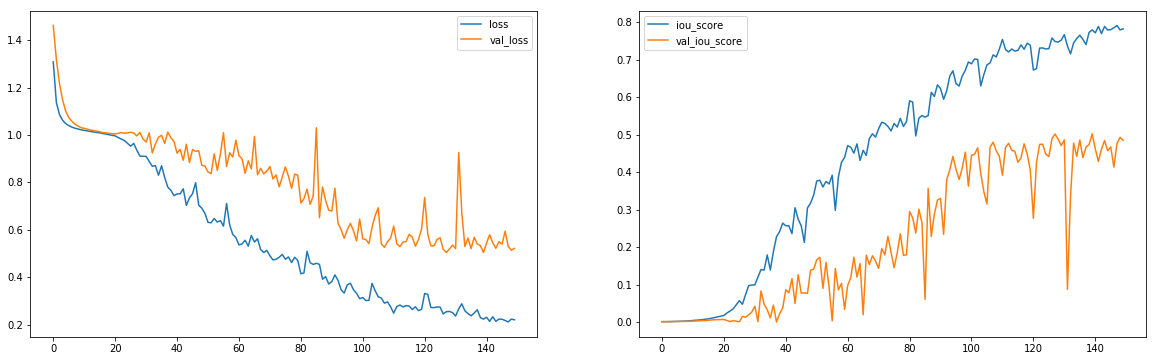

In [31]:
fig=plt.figure(figsize=(20, 6))
fig, axs = plt.subplots(1,2, figsize=(20, 6))
axs[1].plot(history.history['iou_score'], label='iou_score')
axs[1].plot(history.history['val_iou_score'],label='val_iou_score')

axs[1].legend()
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'],label='val_loss')

axs[0].legend()

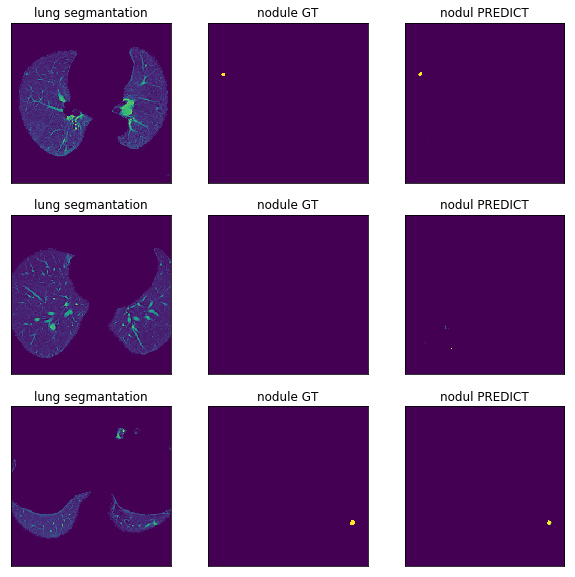

In [32]:
x, y = train_gen.__getitem__(1)
pred=model.predict(x)
pred=np.squeeze(pred)
p=pred>0.5
fig, axs = plt.subplots(3, 3,figsize=(10,10))
for i in range(3): 
    axs[i,0].imshow(x[i])
    axs[i,0].set_title("lung segmantation")   
    axs[i,1].imshow(y[i])
    axs[i,1].set_title("nodule GT")
    axs[i,2].imshow(pred[i])
    axs[i,2].set_title("nodul PREDICT")
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

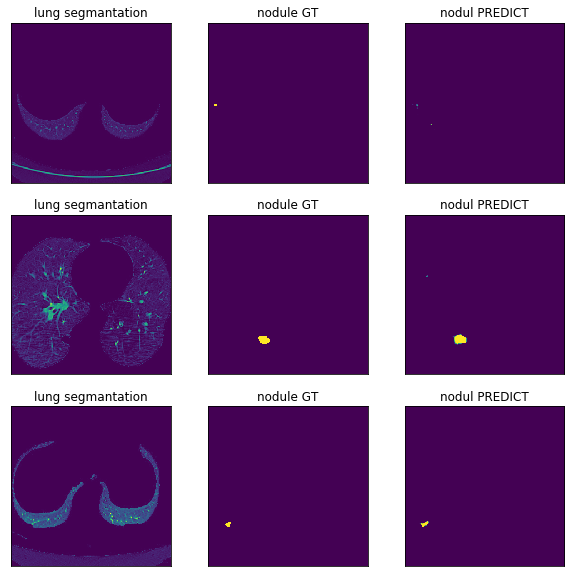

In [35]:
x, y = valid_gen.__getitem__(0)
pred=model.predict(x)
pred=np.squeeze(pred)
p=pred>0.5
fig, axs = plt.subplots(3, 3,figsize=(10,10))
for i in range(3): 
    axs[i,0].imshow(x[i])
    axs[i,0].set_title("lung segmantation")   
    axs[i,1].imshow(y[i])
    axs[i,1].set_title("nodule GT")
    axs[i,2].imshow(pred[i])
    axs[i,2].set_title("nodul PREDICT")
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

In [36]:
iou=sm.metrics.IOUScore()
from sklearn.metrics import confusion_matrix

In [37]:
def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
#     print(current)
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [39]:
model.save_weights(r"J:\yasin\denemeler\dnm19\sre_model_final.hdf5")

In [ ]:
model.load_weights(r"J:\yasin\denemeler\dnm19\vgg16_model_best.hdf5")

In [40]:
def calcMeanIOU(gen):
    iou = []    
    for i in range(len(gen)):    
        x, y = gen.__getitem__(i)    
        pred=model.predict(x)
        pred=np.squeeze(pred)
        p=pred>0.3
        for j in range(x.shape[0]):
            if compute_iou(y[j],p[j]) != np.nan:
                iou.append(compute_iou(y[j],p[j]))            

    iou=np.nan_to_num(iou,nan=0)
    print(np.mean(iou))      

In [41]:
calcMeanIOU(valid_gen)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


0.6417614541652489


In [42]:
calcMeanIOU(train_gen)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


0.8575328534702563
